# Project 5 Part 2 - MCMC

Continued from Part 1: 



In [1]:
import pandas as pd
import numpy as np
import datetime
import emcee
import corner
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Load data from Part 1
# the two dataframes are normalized (aside from dummy variables)

norms_df = pd.read_csv('norms.csv',usecols=[1,2,3])
good_df = pd.read_csv('good_loans.csv',usecols=[1,2,3,4,5,6,7,8])
bad_df = pd.read_csv('bad_loans.csv',usecols=[1,2,3,4,5,6,7,8])


## Resample the data to balance good vs bad loans

In [3]:
bad = bad_df.values.tolist()
bad_df.count()

status             24310
loan_amnt          24310
income             24310
dti                24310
int_rate_p         24310
home_OWN           24310
home_MORTGAGE      24310
term_ 36 months    24310
dtype: int64

In [4]:
good_sample = good_df.sample(n=24310).values.tolist()

In [5]:
balanced = bad + good_sample # full list of balanced loans (all bad, equal # of good)
len(balanced)

48620

# The Distribution Model

### Likelihood

$$g(x) =\omega_0 + \omega_1loan\_amt + \omega_2income + \omega_3dti+ \omega_4int\_rate\_p + \omega_5 OWN + \omega_6 MORTGAGE+ \omega_7 36month$$ 

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

$$p = \sigma(g) = \frac{1}{1+e^{-g}}$$

So the atom of the likelihood becomes: 
$$log(\sigma(g)) = -log({1+e^{-g}})$$

### Prior

For the Prior $\pi$ we chose the following over $\omega_0,\omega_1, \omega_2, \omega_3, \omega_4, \omega_5, \omega_6, \omega_7$:

$$ \pi(\omega) = \frac{1}{2 \pi} e^{-\frac{1}{2}\omega_0^2}e^{-\frac{1}{2}\omega_1^2} e^{-\frac{1}{2}\omega_2^2} e^{-\frac{1}{2}\omega_3^2} e^{-\frac{1}{2}\omega_4^2} e^{-\frac{1}{2}\omega_5^2} e^{-\frac{1}{2}\omega_6^2} e^{-\frac{1}{2}\omega_7^2} $$

the log prior is:

$$ =  -\frac{1}{2}(\omega_0^2 + \omega_1^2+ \omega_2^2 + \omega_3^2 + \omega_4^2 + \omega_5^2 + \omega_6^2 + \omega_7^2) $$



#### Constraints

1. if status == 1 then return P
2. if status == 0 then return 1-p


## Distribution Methods

In [6]:
# w is variables
# d is data

# data defined before methods
# converts dataframe to list to be fed to regression class
# .samples give us a smaller dataset for use during testing

items = 5000 # number of items from each list (less than 24,310)
# ensures balanced number of good and bad loans in data sample
d_sample = bad_df.sample(n=items).values.tolist() + good_df.sample(n=items).values.tolist()

# d[0] holds the loan status, helps to line up other d's with corresponding w's, as w[0] has 
# no corresponding d for the calculations

# var_names = ['Omega0', 'Omega1', 'Omega2','Omega3','Omega4','Omega5','Omega6','Omega7']

sigmoid = lambda g: 1./(1+np.exp(-g))

def log_predictive(w,data):
    # g = w[0] + np.sum([w[i]*data[i] for i in range(1,8)])
    g = w[0] + w[1]*data[1] + w[2]*data[2] + w[3]*data[3] + w[4]*data[4]\
        + w[5]*data[5] + w[6]*data[6] + w[7]*data[7]
    if data[0] == 1:
        return np.log(sigmoid(g))
    else:
        return np.log(1 - sigmoid(g))

def log_prior(w):
    return -0.5 * np.sum([i**2 for i in w]) 

def lnprob(w):
    return log_prior(w) + np.sum([log_predictive(w,d) for d in d_sample])

### Run MCMC on distributions

In [7]:
# Run MCMC - pulled out of class & method to debug, will renest in method if time permits

steps = 10000 # number of steps

nwalkers = 20
ndim = 8 # reduced by two variables (remove 1 each from sets of dummy variables)
p0 = np.random.rand(nwalkers*ndim).reshape((nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, steps)
samples = sampler.flatchain

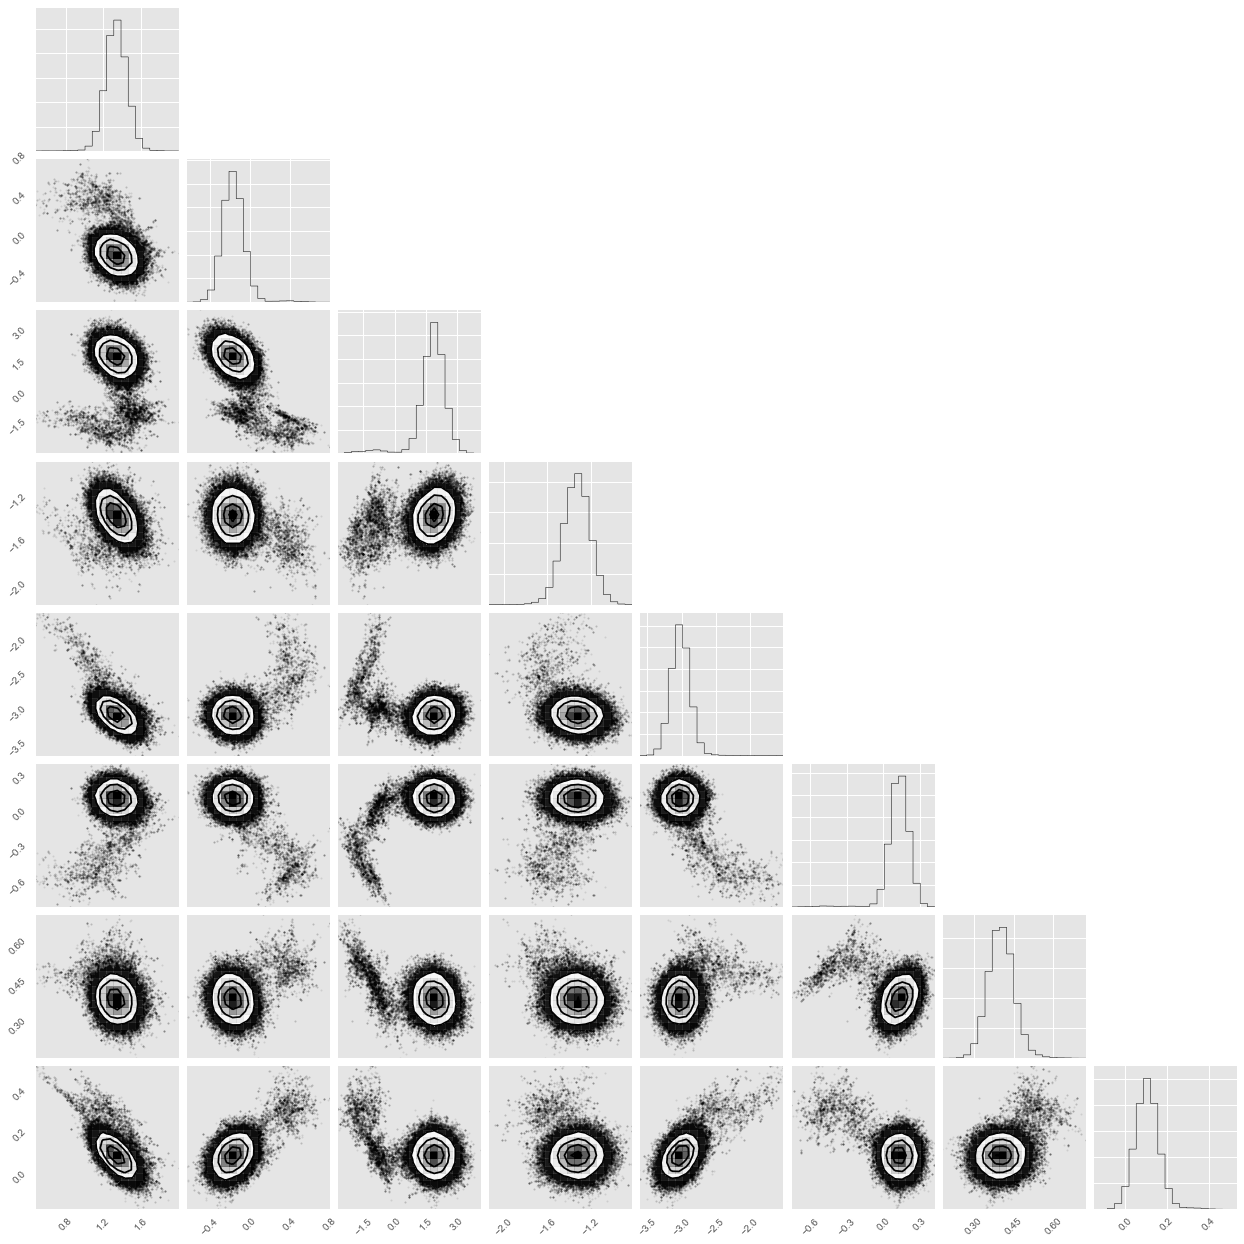

In [8]:
fig = corner.corner(samples)

In [9]:
# find MAP
from scipy.optimize import minimize
rls = lambda w: -lnprob(w)
minRLS = minimize(lambda w: rls(w),[0,0,0,0,0,0,0,0])
minRLS.x

array([ 1.33042487, -0.17342747,  1.92037928, -1.32874063, -3.01579461,
        0.12903568,  0.39878407,  0.10152096])

In [10]:
# Data needed for Part 3

MC_samples = pd.DataFrame(samples)
MC_samples.to_csv('MC_samples.csv')

Continued in part 3.